In [68]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree

In [69]:
# tr = training set
# ts = test set

df_tr = pd.read_csv('./dataset (missing + split)/processed.csv', skipinitialspace=True)
df_ts = pd.read_csv('./dataset (missing + split)/test_processed.csv', skipinitialspace=True)

In [70]:
df_tr.drop(columns=['name', 'album_name', 'artists'], inplace=True)

In [71]:
cat = ['explicit','key','mode','time_signature','genre']
num = [col for col in df_tr.columns if col not in cat]

In [72]:
df_ts.drop(columns=['Unnamed: 0'], inplace=True)

Usiamo l'attributo 'genre' come target

In [73]:
target = 'genre'
cat.remove(target)

# Multiclass task

## K-NN Classifier

In [74]:
# TR set (input e target)
X_tr = df_tr[num].values
y_tr = df_tr[target]

# TS set (input e target)
X_ts = df_ts[num].values
y_ts = df_ts[target]

In [8]:
# Input viene normalizzato perché K-NN è distance based

norm = StandardScaler()
norm.fit(X_tr)

X_tr_norm = norm.transform(X_tr)
X_ts_norm = norm.transform(X_ts)

In [9]:
%%time

# Iperparametri scelti con grid search + k-fold cross validation
param_grid = {
    "n_neighbors": np.arange(start=10, stop=1000, step=10),
    "weights": ["distance", "uniform"],
    "metric": ["euclidean", "cityblock"],
}

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_tr_norm, y_tr)
clf = grid_search.best_estimator_

Fitting 5 folds for each of 396 candidates, totalling 1980 fits
CPU times: user 6.85 s, sys: 1.63 s, total: 8.48 s
Wall time: 15min 25s


In [10]:
# Miglior modello trovato
print(grid_search.best_params_, grid_search.best_score_)

{'metric': 'cityblock', 'n_neighbors': 20, 'weights': 'distance'} 0.508494983277592


In [11]:
%%time

# La ricerca viene ripetuta, modificando la granularità per n_neighbors
param_grid = {
    "n_neighbors": np.arange(start=15, stop=25, step=1),
    "weights": ["distance", "uniform"],
    "metric": ["euclidean", "cityblock"],
}

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_tr_norm, y_tr)
clf = grid_search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'metric': 'cityblock', 'n_neighbors': 18, 'weights': 'distance'} 0.5090301003344482
CPU times: user 490 ms, sys: 83.6 ms, total: 573 ms
Wall time: 31.3 s


In [ ]:
print(grid_search.best_params_, grid_search.best_score_)

Miglior modello con i seguenti iperparametri:
- metric: cityblock
- n_neighbors: 18
- weights: distance

In [9]:
clf = KNeighborsClassifier(metric='cityblock', n_neighbors=18, weights='distance')
clf.fit(X_tr_norm, y_tr)

KNeighborsClassifier(metric='cityblock', n_neighbors=18, weights='distance')

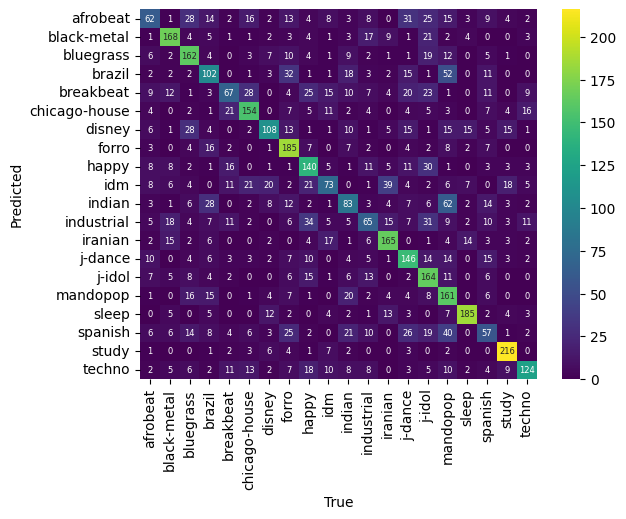

In [10]:
cf = confusion_matrix(y_ts, clf.predict(X_ts_norm))

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="viridis", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(df_tr['genre'].unique()));
ax.yaxis.set_ticklabels(labels=np.sort(df_tr['genre'].unique()));
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/knn_confmatrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Overview delle varie misure per il miglior modello trovato
print(classification_report(y_ts, clf.predict(X_ts_norm)))

               precision    recall  f1-score   support

     afrobeat       0.42      0.25      0.31       250
  black-metal       0.66      0.67      0.67       250
    bluegrass       0.55      0.65      0.59       249
       brazil       0.44      0.41      0.43       248
    breakbeat       0.44      0.27      0.33       249
chicago-house       0.60      0.62      0.61       250
       disney       0.59      0.44      0.50       247
        forro       0.53      0.74      0.62       250
        happy       0.47      0.56      0.51       250
          idm       0.45      0.29      0.36       248
       indian       0.39      0.33      0.36       249
   industrial       0.38      0.26      0.31       250
      iranian       0.62      0.67      0.64       247
      j-dance       0.48      0.59      0.53       249
       j-idol       0.44      0.66      0.52       250
     mandopop       0.37      0.64      0.47       250
        sleep       0.78      0.75      0.76       248
      spa

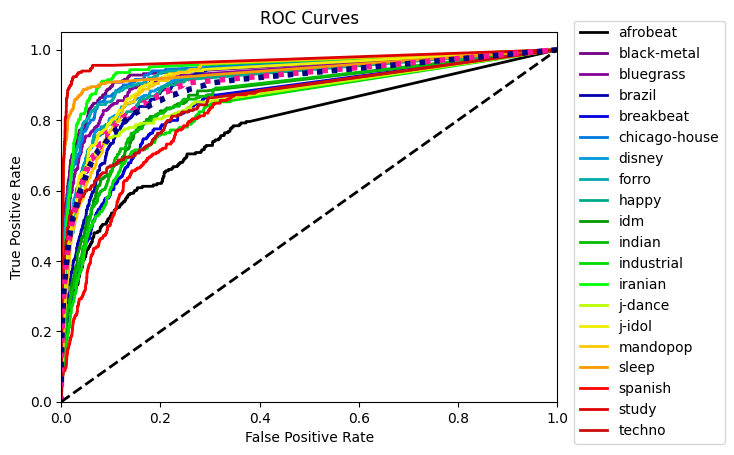

In [11]:
# ROC curve per K-NN
y_ts_pred_proba = clf.predict_proba(X_ts_norm) 
plot_roc(y_ts, y_ts_pred_proba)
plt.legend(labels = np.sort(df_tr['genre'].unique()), bbox_to_anchor=(1.02, 1.05))
plt.savefig('./img/knn_multi_roc.png', dpi=300, bbox_inches='tight')
plt.show()

## Decision Tree Classifier

In [12]:
# TR set (input e target)
X_tr = df_tr.drop(columns=[target]).values
y_tr = df_tr[target]

# TS set (input e target)
X_ts = df_ts.drop(columns=[target]).values
y_ts = df_ts[target]

# Non c'è bisogno di normalizzare, perché Decision Tree non è distance based

In [7]:
%%time

# Ricerca di iperparametri come sopra ('None' a max_depth corrisponde a nessun limite di profondità)
param_grid = {
    'max_depth': list(np.arange(1, 102, step=10)) + [None],
    'min_samples_split': [2, 4, 8, 16, 32, 64, 128, 256, 512],
    'min_samples_leaf': [2, 4, 8, 16, 32, 64, 128, 256, 512],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_tr, y_tr)
clf = grid_search.best_estimator_

Fitting 5 folds for each of 1782 candidates, totalling 8910 fits
CPU times: user 1min 46s, sys: 5.39 s, total: 1min 51s
Wall time: 7min 16s


In [8]:
print(grid_search.best_params_, grid_search.best_score_)

{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 8, 'min_samples_split': 32} 0.46347826086956523


In [25]:
%%time

# Come sopra, ricerca espandendo un range di parametri
param_grid = {
    'max_depth': list(np.arange(1, 20, step=1)),
    'min_samples_split': [16, 32, 64],
    'min_samples_leaf': [4, 8, 16],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_tr, y_tr)
clf = grid_search.best_estimator_

Fitting 5 folds for each of 342 candidates, totalling 1710 fits
CPU times: user 12.1 s, sys: 797 ms, total: 12.9 s
Wall time: 1min 8s


In [26]:
print(grid_search.best_params_, grid_search.best_score_)

{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 8, 'min_samples_split': 32} 0.4636789297658863


Miglior modello con i seguenti iperparametri:
- criterion: gini
- max_depth: 11
- min_samples_leaf: 8
- min_samples_split: 32

In [75]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=11, min_samples_leaf=8, min_samples_split=32)
clf.fit(X_tr, y_tr)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=8, min_samples_split=32)

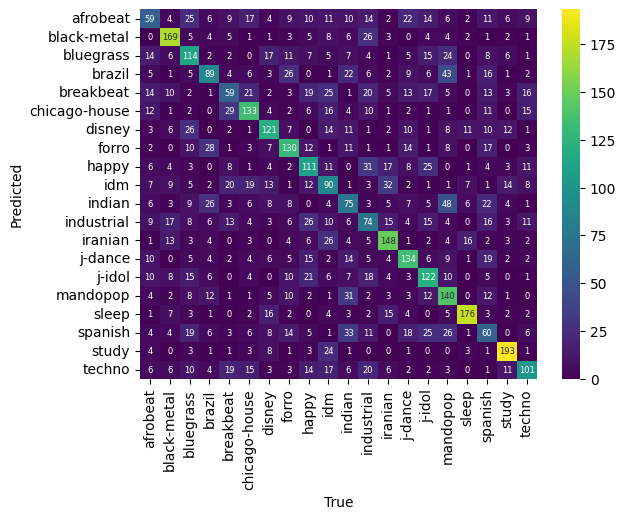

In [14]:
cf = confusion_matrix(y_ts, clf.predict(X_ts))

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="viridis", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(df_tr['genre'].unique()));
ax.yaxis.set_ticklabels(labels=np.sort(df_tr['genre'].unique()));
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/dectree_confmatrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
print(classification_report(y_ts, clf.predict(X_ts)))

               precision    recall  f1-score   support

     afrobeat       0.33      0.24      0.28       250
  black-metal       0.63      0.68      0.65       250
    bluegrass       0.41      0.46      0.43       249
       brazil       0.44      0.36      0.40       248
    breakbeat       0.33      0.24      0.27       249
chicago-house       0.53      0.53      0.53       250
       disney       0.52      0.49      0.50       247
        forro       0.51      0.52      0.51       250
        happy       0.41      0.44      0.42       250
          idm       0.32      0.36      0.34       248
       indian       0.30      0.30      0.30       249
   industrial       0.29      0.30      0.29       250
      iranian       0.56      0.60      0.58       247
      j-dance       0.51      0.54      0.52       249
       j-idol       0.45      0.49      0.47       250
     mandopop       0.40      0.56      0.47       250
        sleep       0.78      0.71      0.74       248
      spa

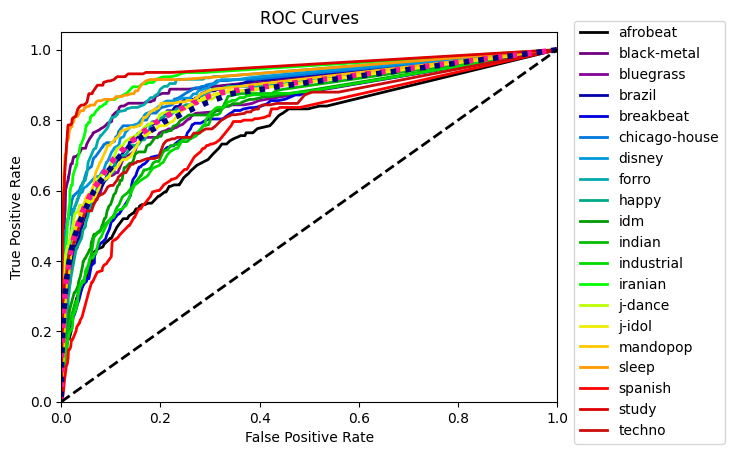

In [15]:
# ROC curve per K-NN
y_ts_pred_proba = clf.predict_proba(X_ts) 
plot_roc(y_ts, y_ts_pred_proba)
plt.legend(labels = np.sort(df_tr['genre'].unique()), bbox_to_anchor=(1.02, 1.05))
plt.savefig('./img/dectree_multi_roc.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/dt/1fn71bpx79xgdp8ds17s_9f40000gn/T/ipykernel_23898/1974794075.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


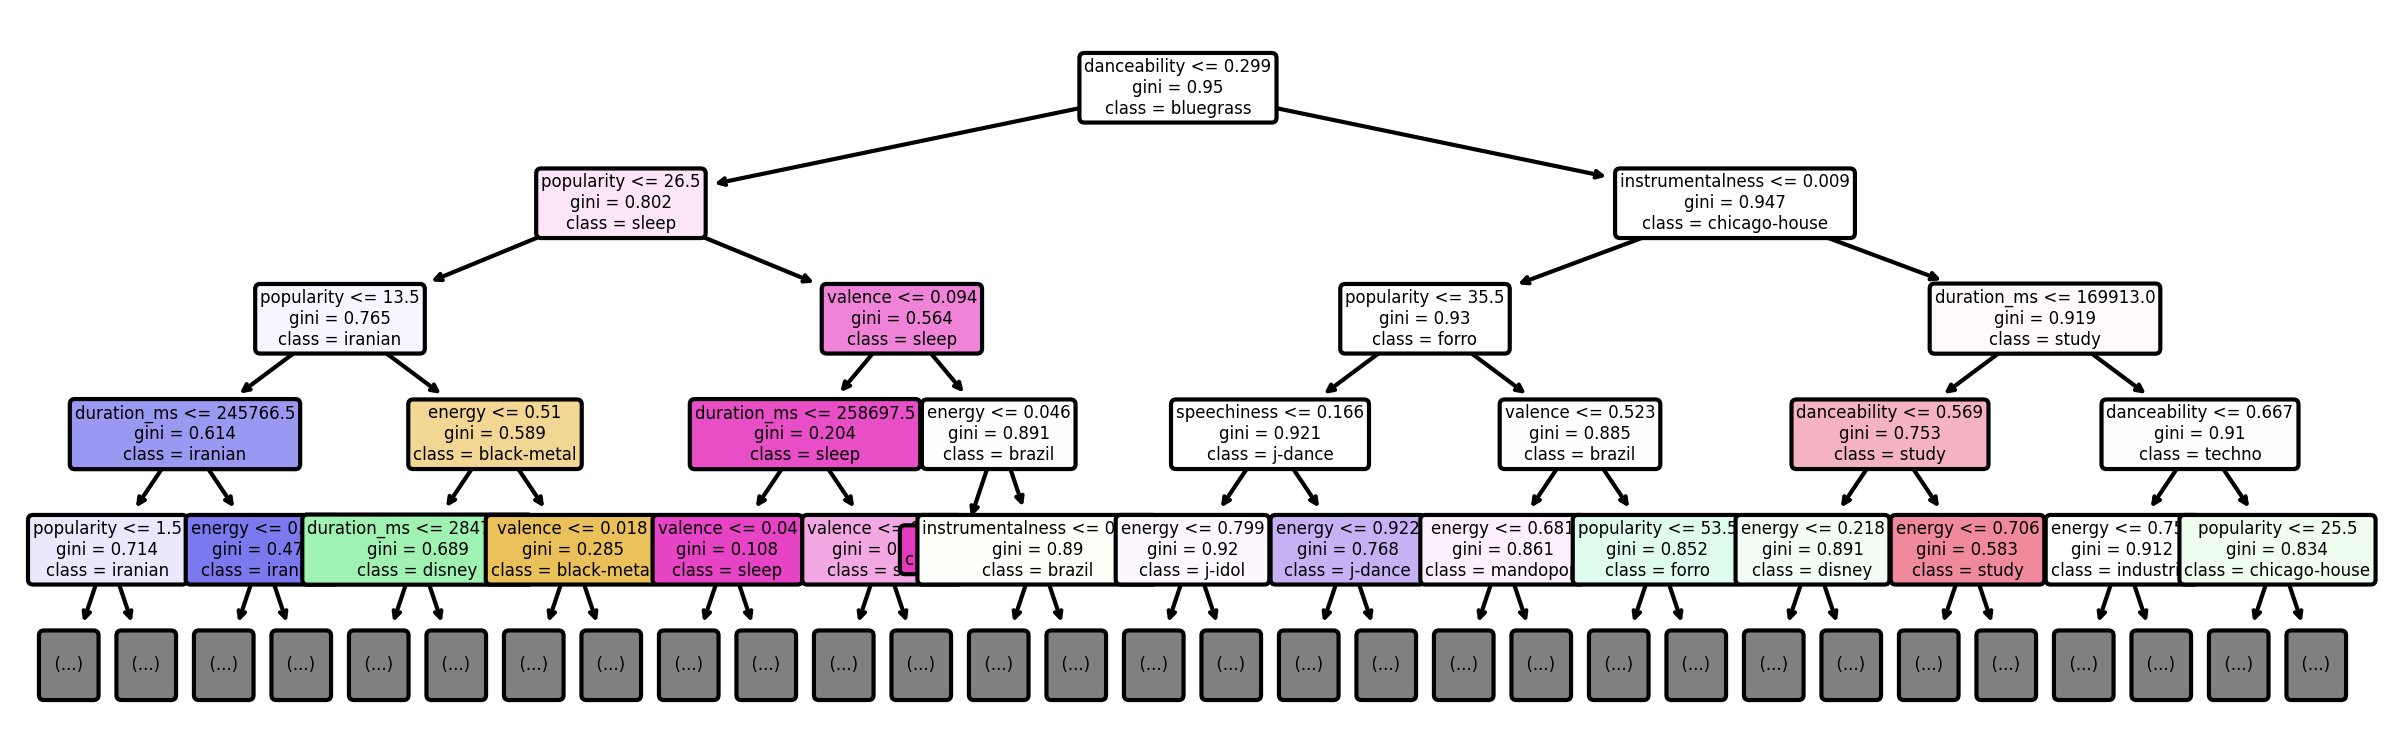

In [18]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=300)

import matplotlib
import re
def replace_text(obj):
    if type(obj) == matplotlib.text.Annotation:
        txt = obj.get_text()
        txt = re.sub("\nsamples[^$]*class","\nclass",txt)
        obj.set_text(txt)
    return obj
plot_tree(
    clf,
    feature_names=df_tr.columns,
    filled=True,
    max_depth=4,
    rounded=True,
    fontsize=4,
    class_names=np.sort(df_tr['genre'].unique()),
)
ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]
plt.savefig('./img/dectree_multi_tree.png', dpi=300, bbox_inches='tight')
fig.show()

/var/folders/dt/1fn71bpx79xgdp8ds17s_9f40000gn/T/ipykernel_23898/2311177910.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


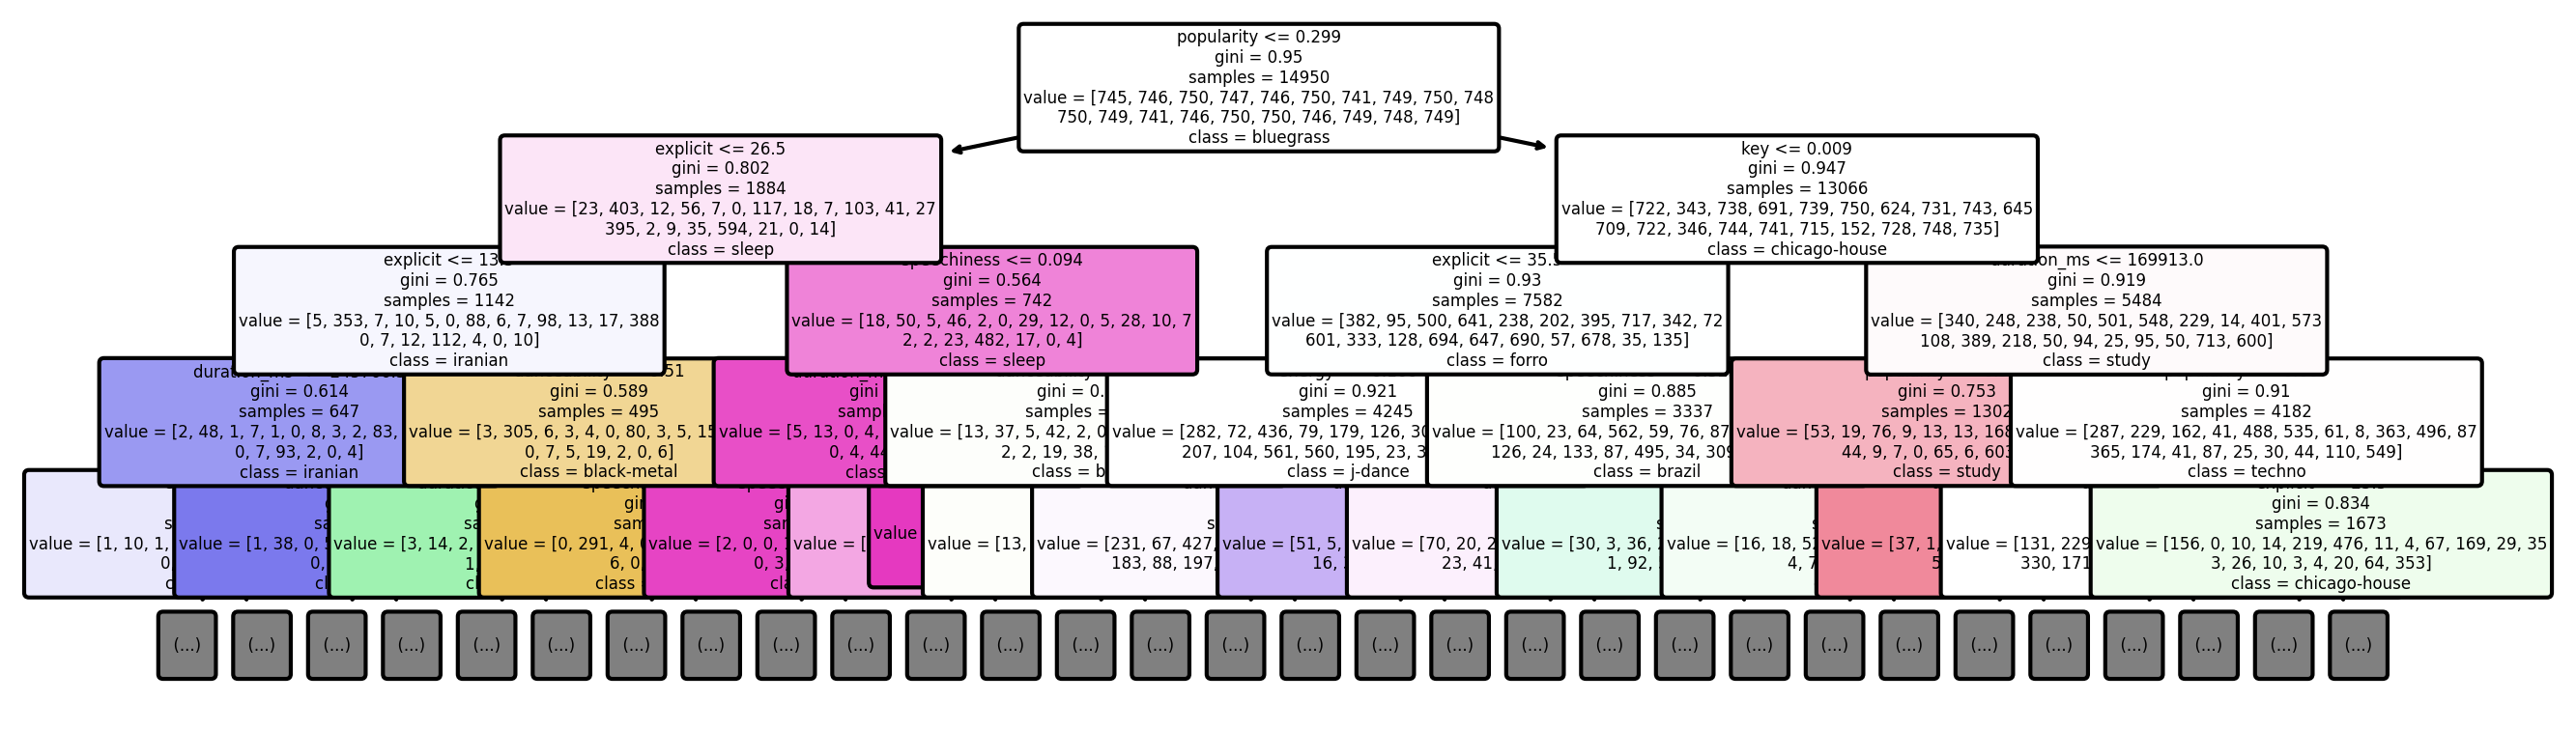

In [77]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
plot_tree(
    clf,
    feature_names=df_tr.columns,
    filled=True,
    max_depth=4,
    rounded=True,
    fontsize=4,
    class_names=np.sort(df_tr['genre'].unique()),
)
fig.show()

## Naive Bayes Classifier

In [51]:
# TR set (input e target)
X_tr = df_tr[num].values
y_tr = df_tr[target]

# TS set (input e target)
X_ts = df_ts[num].values
y_ts = df_ts[target]

In [52]:
clf = GaussianNB()
clf.fit(X_tr, y_tr)

GaussianNB()

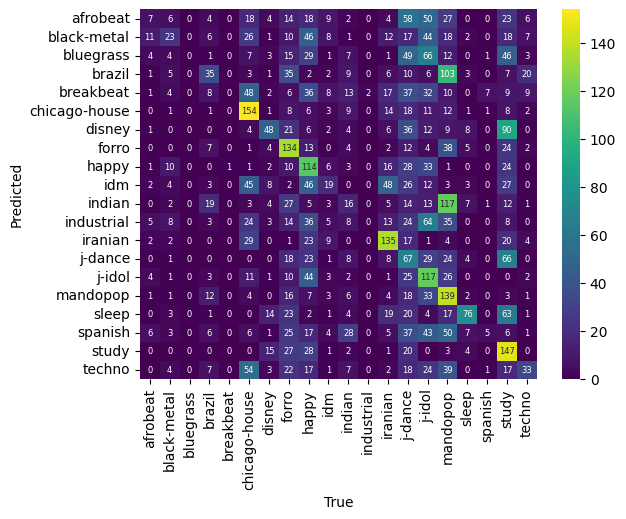

In [53]:
cf = confusion_matrix(y_ts, clf.predict(X_ts))

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="viridis", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(df_tr['genre'].unique()));
ax.yaxis.set_ticklabels(labels=np.sort(df_tr['genre'].unique()));
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/naivegaussian_confmatrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [125]:
y_pred = clf.predict(X_ts)
print(classification_report(y_ts, y_pred, zero_division=0.0))

               precision    recall  f1-score   support

     afrobeat       0.15      0.03      0.05       250
  black-metal       0.28      0.09      0.14       250
    bluegrass       0.00      0.00      0.00       249
       brazil       0.30      0.14      0.19       248
    breakbeat       0.00      0.00      0.00       249
chicago-house       0.35      0.62      0.45       250
       disney       0.42      0.19      0.27       247
        forro       0.31      0.54      0.39       250
        happy       0.22      0.46      0.30       250
          idm       0.21      0.08      0.11       248
       indian       0.12      0.06      0.08       249
   industrial       0.00      0.00      0.00       250
      iranian       0.42      0.55      0.48       247
      j-dance       0.12      0.27      0.17       249
       j-idol       0.20      0.47      0.28       250
     mandopop       0.20      0.56      0.30       250
        sleep       0.62      0.31      0.41       248
      spa

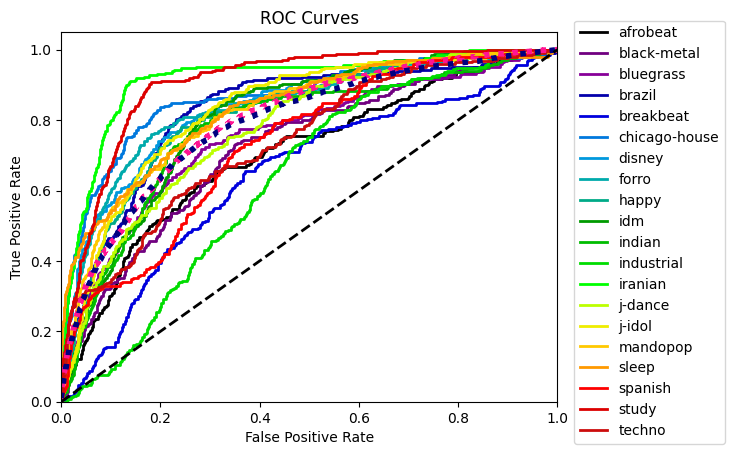

In [24]:
# ROC curve per K-NN
y_ts_pred_proba = clf.predict_proba(X_ts) 
plot_roc(y_ts, y_ts_pred_proba)
plt.legend(labels = np.sort(df_tr['genre'].unique()), bbox_to_anchor=(1.02, 1.05))
plt.savefig('./img/naivegaussian_multi_roc.png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
# Train the classifier
clf.fit(X_tr, y_tr)

MultinomialNB()

In [56]:
y_pred = clf.predict(X_ts)
print(classification_report(y_ts, y_pred, zero_division=0.0))

               precision    recall  f1-score   support

     afrobeat       0.21      0.07      0.10       250
  black-metal       0.19      0.08      0.11       250
    bluegrass       0.11      0.02      0.03       249
       brazil       0.23      0.21      0.22       248
    breakbeat       0.10      0.06      0.07       249
chicago-house       0.13      0.22      0.16       250
       disney       0.17      0.30      0.22       247
        forro       0.17      0.31      0.22       250
        happy       0.17      0.33      0.22       250
          idm       0.17      0.19      0.18       248
       indian       0.18      0.20      0.19       249
   industrial       0.06      0.02      0.03       250
      iranian       0.29      0.64      0.40       247
      j-dance       0.22      0.10      0.14       249
       j-idol       0.29      0.14      0.18       250
     mandopop       0.27      0.04      0.07       250
        sleep       0.24      0.30      0.26       248
      spa

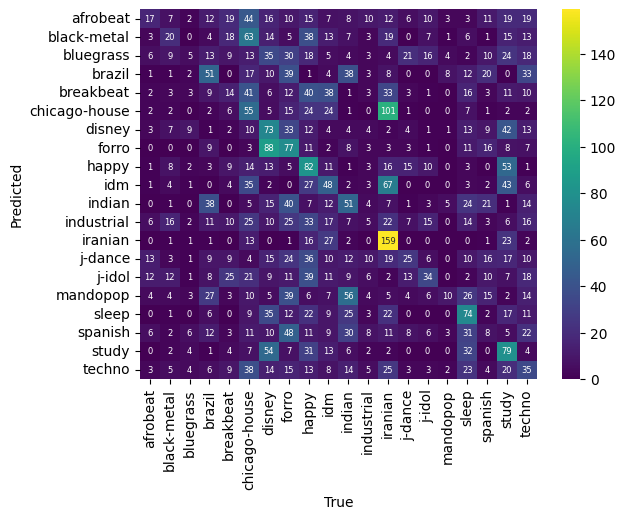

In [57]:
cf = confusion_matrix(y_ts, clf.predict(X_ts))

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="viridis", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(df_tr['genre'].unique()));
ax.yaxis.set_ticklabels(labels=np.sort(df_tr['genre'].unique()));
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/naivemultinomial_confmatrix.png', dpi=300, bbox_inches='tight')

plt.show()

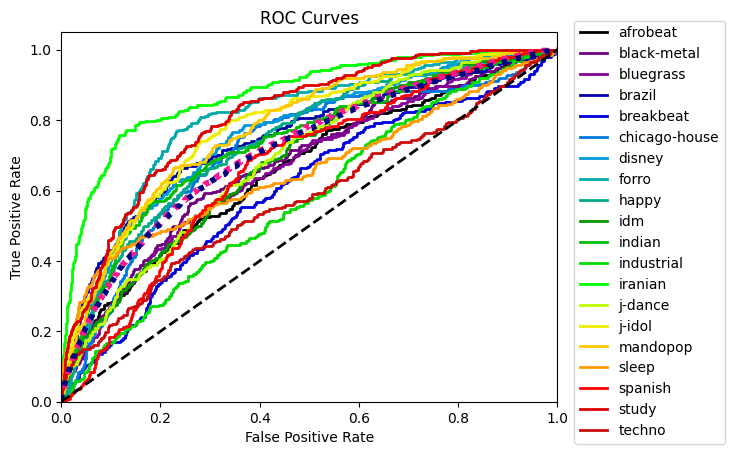

In [27]:
# ROC curve per K-NN
y_ts_pred_proba = clf.predict_proba(X_ts) 
plot_roc(y_ts, y_ts_pred_proba)
plt.legend(labels = np.sort(df_tr['genre'].unique()), bbox_to_anchor=(1.02, 1.05))
plt.savefig('./img/naivemultinomial_multi_roc.png', dpi=300, bbox_inches='tight')

plt.show()

L'analisi viene ripetuta isolando un genere dagli altri

# Binary task

In [62]:
target = 'genre'

# Le classi vengono divise in due gruppi: techno e non-techno
genre_dict = {}

for val in df_tr[target].unique():
    genre_dict[val] = 'not techno'
genre_dict['techno'] = 'techno'

In [63]:
df_tr['genre'] = df_tr['genre'].map(genre_dict)
df_ts['genre'] = df_ts['genre'].map(genre_dict)

## K-NN Classifier

In [30]:
# TR set (input e target)
X_tr = df_tr[num].values
y_tr = df_tr[target]

# TS set (input e target)
X_ts = df_ts[num].values
y_ts = df_ts[target]

In [31]:
# Input viene normalizzato perché K-NN è distance based

norm = StandardScaler()
norm.fit(X_tr)

X_tr_norm = norm.transform(X_tr)
X_ts_norm = norm.transform(X_ts)

In [70]:
%%time

# Iperparametri scelti con grid search + k-fold cross validation
param_grid = {
    "n_neighbors": np.arange(start=10, stop=1000, step=10),
    "weights": ["distance", "uniform"],
    "metric": ["euclidean", "cityblock"],
}

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_tr_norm, y_tr)
clf = grid_search.best_estimator_

Fitting 5 folds for each of 396 candidates, totalling 1980 fits
CPU times: user 5 s, sys: 1.28 s, total: 6.28 s
Wall time: 10min 40s


In [71]:
# Miglior modello trovato
print(grid_search.best_params_, grid_search.best_score_)

{'metric': 'cityblock', 'n_neighbors': 20, 'weights': 'distance'} 0.9644816053511706


In [72]:
%%time

# La ricerca viene ripetuta, modificando la granularità per n_neighbors
param_grid = {
    "n_neighbors": np.arange(start=15, stop=25, step=1),
    "weights": ["distance", "uniform"],
    "metric": ["euclidean", "cityblock"],
}

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_tr_norm, y_tr)
clf = grid_search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: user 461 ms, sys: 78.8 ms, total: 539 ms
Wall time: 28.2 s


In [73]:
print(grid_search.best_params_, grid_search.best_score_)

{'metric': 'cityblock', 'n_neighbors': 22, 'weights': 'distance'} 0.9646153846153848


Miglior modello con i seguenti iperparametri:
- metric: cityblock
- n_neighbors: 22
- weights: distance

In [32]:
clf = KNeighborsClassifier(metric='cityblock', n_neighbors=22, weights='distance')
clf.fit(X_tr_norm, y_tr)

KNeighborsClassifier(metric='cityblock', n_neighbors=22, weights='distance')

In [28]:
# Overview delle varie misure per il miglior modello trovato
print(classification_report(y_ts, clf.predict(X_ts_norm)))

              precision    recall  f1-score   support

  not techno       0.97      1.00      0.98      4732
      techno       0.83      0.36      0.50       249

    accuracy                           0.96      4981
   macro avg       0.90      0.68      0.74      4981
weighted avg       0.96      0.96      0.96      4981



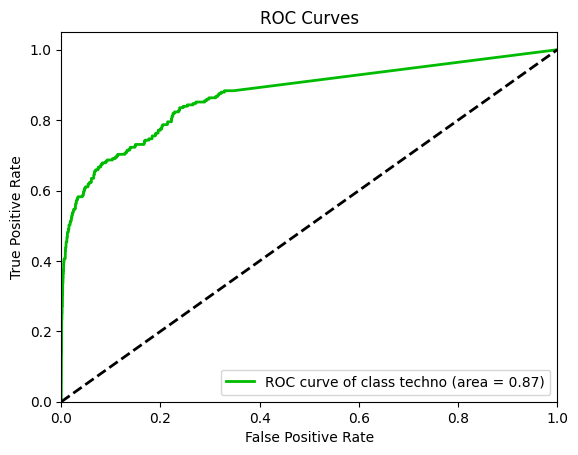

In [33]:
# ROC curve per K-NN

y_ts_pred_proba = clf.predict_proba(X_ts_norm) 
plot_roc(y_ts, y_ts_pred_proba, classes_to_plot='techno', plot_micro=False, plot_macro=False)
plt.savefig('./img/knn_bin_roc.png', dpi=300, bbox_inches='tight')
plt.show()

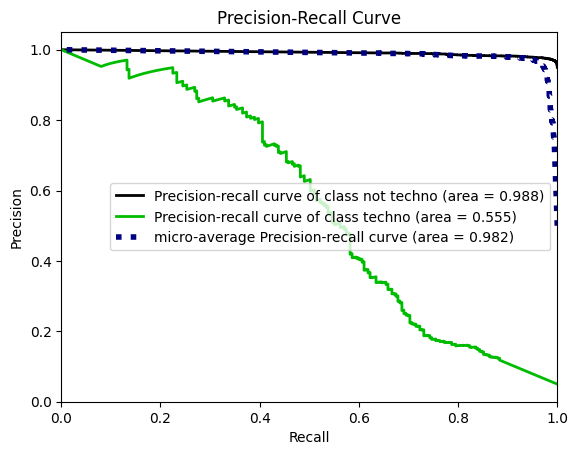

In [83]:
plot_precision_recall(y_ts, clf.predict_proba(X_ts_norm))
plt.show()

## Decision Tree Classifier

In [34]:
# TR set (input e target)
X_tr = df_tr.drop(columns=[target]).values
y_tr = df_tr[target]

# TS set (input e target)
X_ts = df_ts.drop(columns=[target]).values
y_ts = df_ts[target]

# Non c'è bisogno di normalizzare, perché Decision Tree non è distance based

In [78]:
%%time

# Ricerca di iperparametri come sopra ('None' a max_depth corrisponde a nessun limite di profondità)
param_grid = {
    'max_depth': list(np.arange(1, 102, step=10)) + [None],
    'min_samples_split': [2, 4, 8, 16, 32, 64, 128, 256, 512],
    'min_samples_leaf': [2, 4, 8, 16, 32, 64, 128, 256, 512],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_tr, y_tr)
clf = grid_search.best_estimator_

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
CPU times: user 1min, sys: 4.32 s, total: 1min 4s
Wall time: 3min 46s


In [79]:
print(grid_search.best_params_, grid_search.best_score_)

{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 16, 'min_samples_split': 64} 0.9606688963210702


In [80]:
%%time

# Come sopra, ricerca espandendo un range di parametri
param_grid = {
    'max_depth': list(np.arange(1, 20, step=1)),
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [8, 16, 32],
    'criterion': ['gini']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_tr, y_tr)
clf = grid_search.best_estimator_

Fitting 5 folds for each of 171 candidates, totalling 855 fits
CPU times: user 5.08 s, sys: 328 ms, total: 5.41 s
Wall time: 17 s


In [81]:
print(grid_search.best_params_, grid_search.best_score_)

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 16, 'min_samples_split': 32} 0.9610033444816054


Miglior modello con i seguenti iperparametri:
- criterion: gini
- max_depth: 8
- min_samples_leaf: 16
- min_samples_split: 32

In [35]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_leaf=16, min_samples_split=32)
clf.fit(X_tr, y_tr)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=16, min_samples_split=32)

In [32]:
print(classification_report(y_ts, clf.predict(X_ts)))

              precision    recall  f1-score   support

  not techno       0.97      0.99      0.98      4732
      techno       0.74      0.33      0.45       249

    accuracy                           0.96      4981
   macro avg       0.85      0.66      0.72      4981
weighted avg       0.95      0.96      0.95      4981



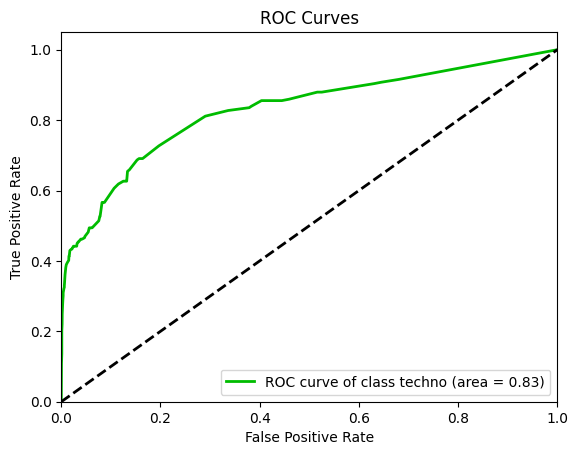

In [36]:
# ROC curve per Decision Tree

y_ts_pred_proba = clf.predict_proba(X_ts) 
plot_roc(y_ts, y_ts_pred_proba, classes_to_plot='techno', plot_micro=False, plot_macro=False)
plt.savefig('./img/knn_bin_roc.png', dpi=300, bbox_inches='tight')
plt.show()

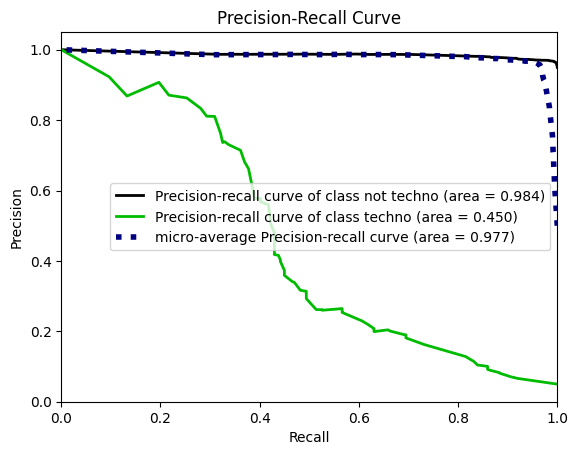

In [30]:
plot_precision_recall(y_ts, clf.predict_proba(X_ts))
plt.show()

/var/folders/dt/1fn71bpx79xgdp8ds17s_9f40000gn/T/ipykernel_23898/3994345986.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


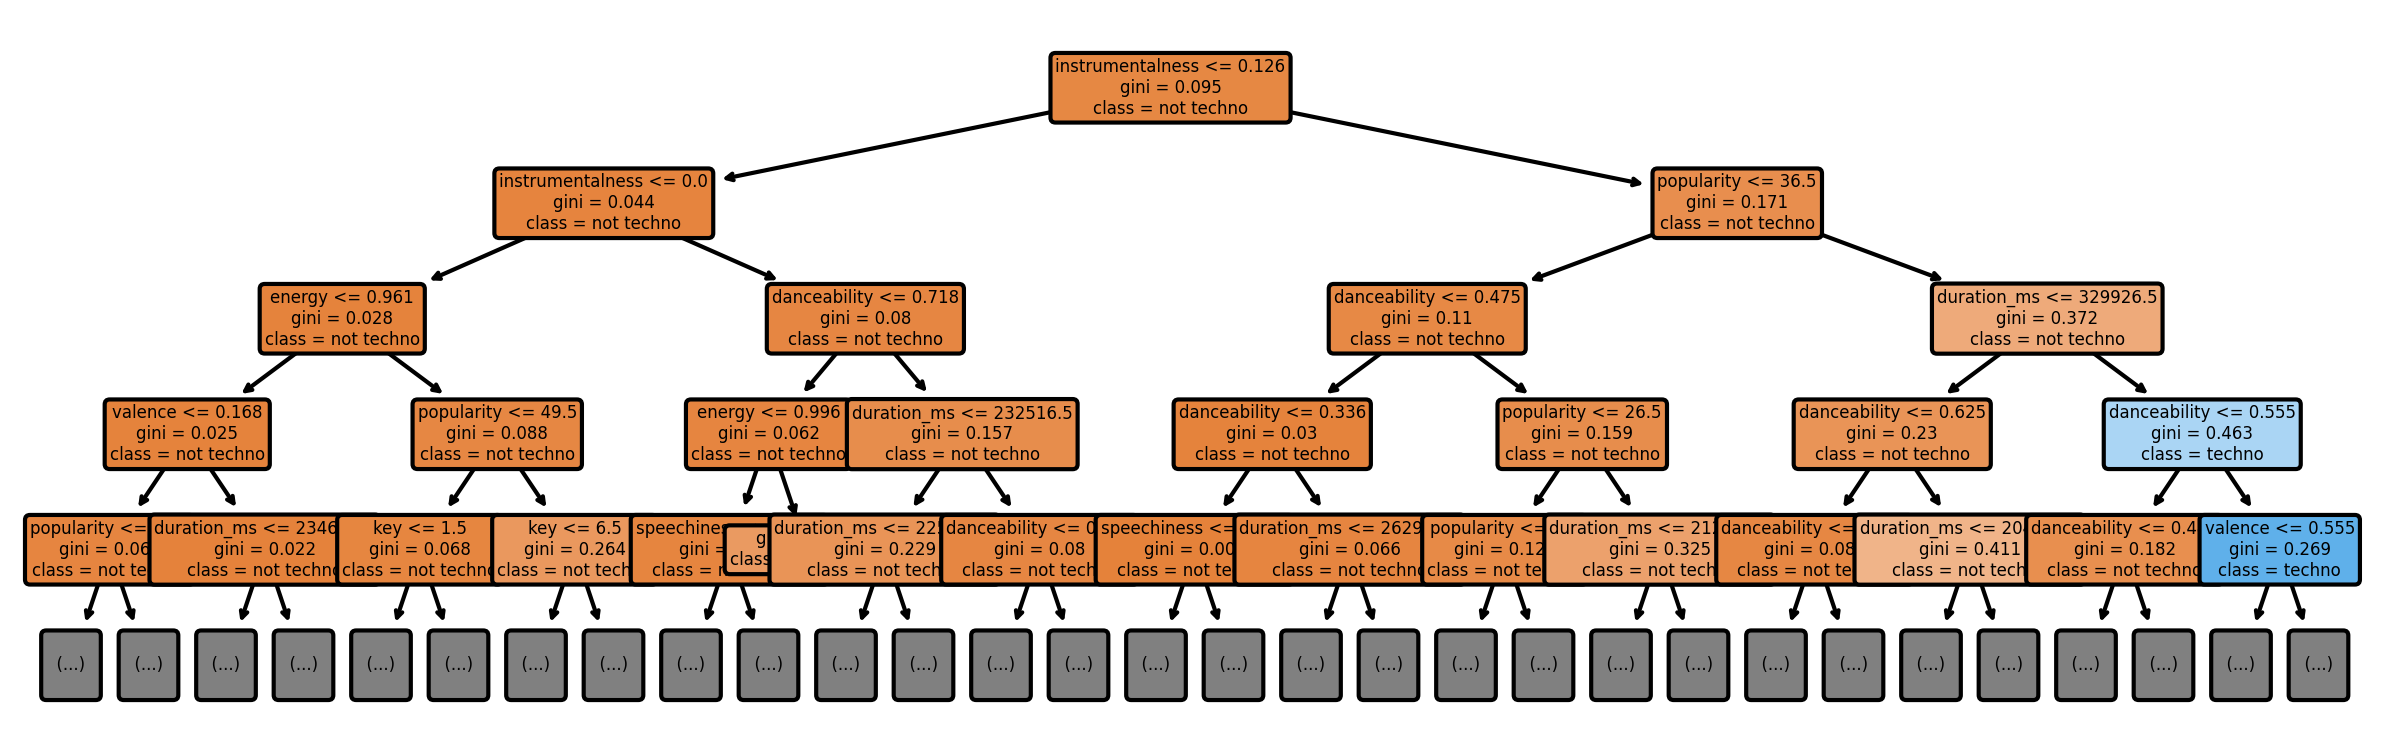

In [37]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=300)

import matplotlib
import re
def replace_text(obj):
    if type(obj) == matplotlib.text.Annotation:
        txt = obj.get_text()
        txt = re.sub("\nsamples[^$]*class","\nclass",txt)
        obj.set_text(txt)
    return obj
plot_tree(
    clf,
    feature_names=df_tr.columns,
    filled=True,
    max_depth=4,
    rounded=True,
    fontsize=4,
    class_names=np.sort(df_tr['genre'].unique()),
)
ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]
plt.savefig('./img/dectree_bin_tree.png', dpi=300, bbox_inches='tight')

fig.show()

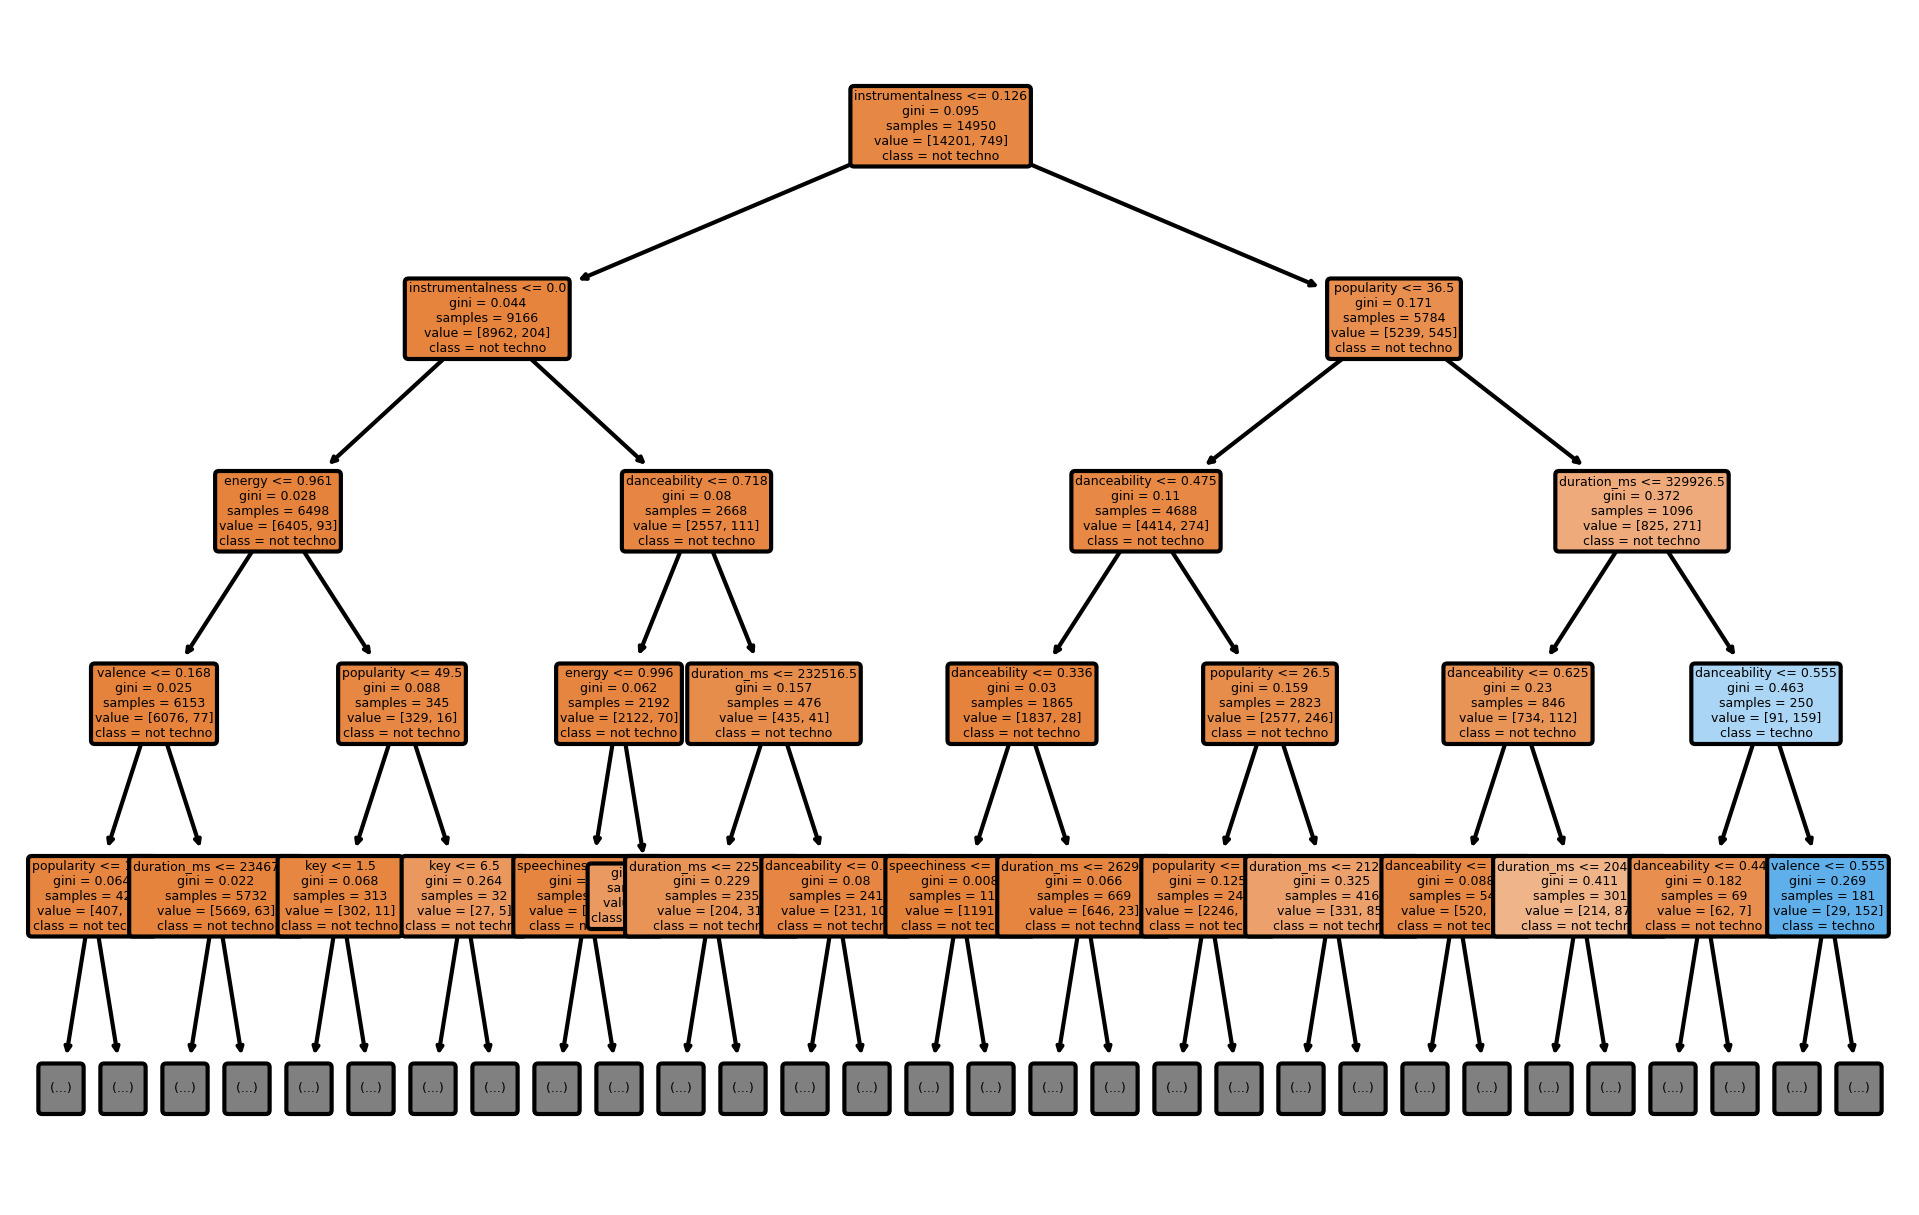

In [106]:
plt.figure(figsize=(8, 5), dpi=300)
plot_tree(clf, feature_names=df_tr.columns, filled=True, max_depth=4, rounded=True, fontsize=3, class_names=np.sort(df_tr['genre'].unique()))
plt.show()

## Naive Bayes Classifier

In [64]:
# TR set (input e target)
X_tr = df_tr[num].values
y_tr = df_tr[target]

# TS set (input e target)
X_ts = df_ts[num].values
y_ts = df_ts[target]

In [59]:
clf = GaussianNB()
clf.fit(X_tr, y_tr)

GaussianNB()

In [40]:
y_pred = clf.predict(X_ts)
print(classification_report(y_ts, y_pred, zero_division=0.0))

              precision    recall  f1-score   support

  not techno       0.95      1.00      0.97      4732
      techno       0.04      0.00      0.01       249

    accuracy                           0.95      4981
   macro avg       0.50      0.50      0.49      4981
weighted avg       0.90      0.95      0.92      4981



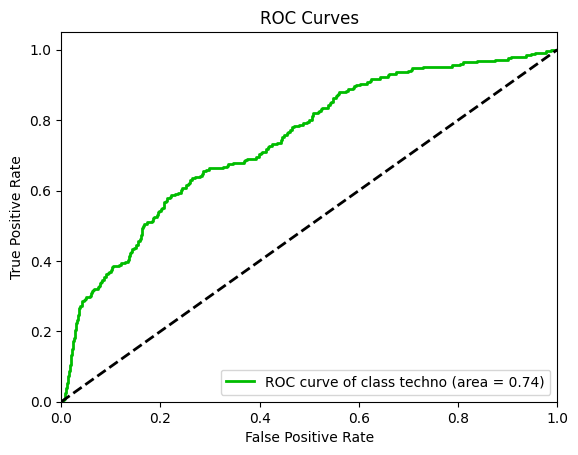

In [41]:
y_ts_pred_proba = clf.predict_proba(X_ts) 
plot_roc(y_ts, y_ts_pred_proba, classes_to_plot='techno', plot_micro=False, plot_macro=False)
plt.savefig(fname='./img/naivegaussian_bin_roc.png', dpi=300, bbox_inches='tight')
plt.show()

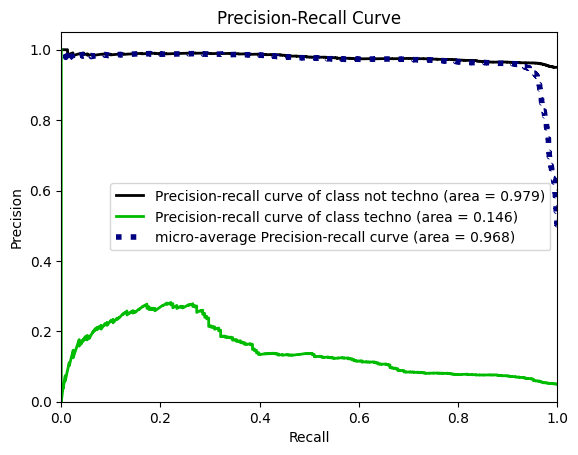

In [39]:
plot_precision_recall(y_ts, clf.predict_proba(X_ts))
plt.show()

In [65]:
clf = MultinomialNB()
clf.fit(X_tr, y_tr)

MultinomialNB()

In [66]:
y_pred = clf.predict(X_ts)
print(classification_report(y_ts, y_pred, zero_division=0.0))

              precision    recall  f1-score   support

  not techno       0.96      0.75      0.84      4732
      techno       0.08      0.43      0.14       249

    accuracy                           0.73      4981
   macro avg       0.52      0.59      0.49      4981
weighted avg       0.92      0.73      0.80      4981



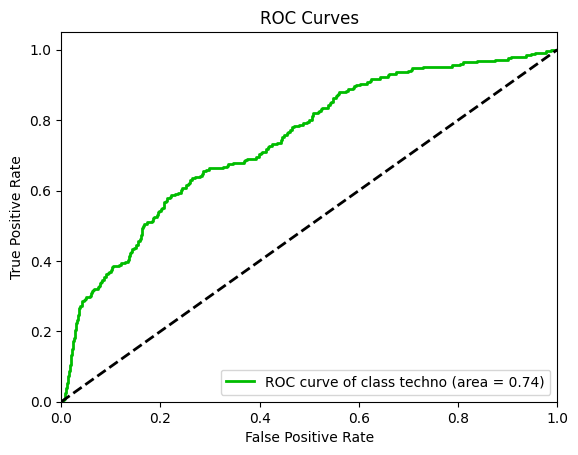

In [67]:
plot_roc(y_ts, y_ts_pred_proba, classes_to_plot='techno', plot_micro=False, plot_macro=False)
plt.savefig(fname='./img/naivemultinomial_bin_roc.png', dpi=300, bbox_inches='tight')
plt.show()